# Define Dependencies

In [1]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral

Using TensorFlow backend.


In [2]:
# Global Variables
windowSize = 5
numPCAcomponents = 30
testRatio = 0.25

# Define the neccesary functions for later use

In [3]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'data')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines.mat'))['indian_pines']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels


def loadHSIData():
    data_path = os.path.join(os.getcwd(), 'HSI_data')
    data = spectral.open_image(os.path.join(data_path, '92AV3C.lan')).load()
    data = np.array(data).astype(np.int32)
    labels = spectral.open_image(os.path.join(data_path, '92AV3GT.GIS')).load()
    labels = np.array(labels).astype(np.uint8)
    labels.shape = (145, 145)
    return data, labels


def reports(X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy


def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [4]:
PATH = os.getcwd()
print (PATH)

/home/danquxunhuan/course/prml/lab2/Indian_pines_classification


In [5]:
X_test = np.load("./predata/XtestWindowSize" 
                 + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
y_test = np.load("./predata/ytestWindowSize" 
                 + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

In [6]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)

In [7]:
# load the model architecture and weights
model = load_model('./model/HSI_model_epochs100.h5')

In [8]:
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion = str(confusion)
file_name = './result/report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

2592/2592 [==============================] - 0s 87us/step


In [9]:
# load the original image
# X, y = loadIndianPinesData()
X, y = loadHSIData()

/home/danquxunhuan/software/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  # This is added back by InteractiveShellApp.init_path()
/home/danquxunhuan/software/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  del sys.path[0]


In [10]:
X, pca = applyPCA(X,numComponents=numPCAcomponents)

In [11]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 5
numComponents = 30

In [12]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        p = int(PATCH_SIZE/2)
        # print(y[i+p][j+p])
        # target = int(y[i+PATCH_SIZE/2, j+PATCH_SIZE/2])
        target = y[i+p][j+p]
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            # print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[i+p][j+p] = prediction+1

In [13]:
ground_truth = spectral.imshow(classes=y, figsize=(5, 5))

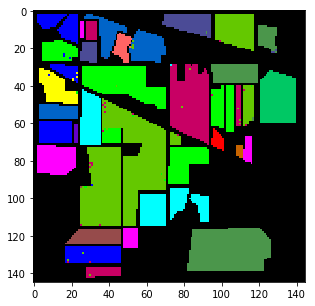

In [14]:
predict_image = spectral.imshow(classes=outputs.astype(int), figsize=(5, 5))